In [1]:
# STEP 1: Import necessary packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the Dataset (from CSV)

In [2]:
# Load the dataset
df = pd.read_csv('NPHA-doctor-visits.csv')

# Inspect the data
df.head()

,Number of Doctors Visited,Age,Phyiscal Health,Mental Health,Dental Health,Employment,Stress Keeps Patient from Sleeping,Medication Keeps Patient from Sleeping,Pain Keeps Patient from Sleeping,Bathroom Needs Keeps Patient from Sleeping,Uknown Keeps Patient from Sleeping,Trouble Sleeping,Prescription Sleep Medication,Race,Gender
0,3,2,4,3,3,3,0,0,0,0,1,2,3,1,2
1,2,2,4,2,3,3,1,0,0,1,0,3,3,1,1
2,3,2,3,2,3,3,0,0,0,0,1,3,3,4,1
3,1,2,3,2,3,3,0,0,0,1,0,3,3,4,2
4,3,2,3,3,3,3,1,0,0,0,0,2,3,1,2


In [3]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Number of Doctors Visited                   714 non-null    int64
 1   Age                                         714 non-null    int64
 2   Phyiscal Health                             714 non-null    int64
 3   Mental Health                               714 non-null    int64
 4   Dental Health                               714 non-null    int64
 5   Employment                                  714 non-null    int64
 6   Stress Keeps Patient from Sleeping          714 non-null    int64
 7   Medication Keeps Patient from Sleeping      714 non-null    int64
 8   Pain Keeps Patient from Sleeping            714 non-null    int64
 9   Bathroom Needs Keeps Patient from Sleeping  714 non-null    int64
 10  Uknown Keeps Patient from Sleeping    

### Clean and prepare the data

In [4]:
# Replace "Refused" or coded missing values with NaN
df.replace([-1, -2, 'Refused', 'Not asked'], np.nan, inplace=True)

# Clean column names for easier referencing
df.columns = df.columns.str.strip().str.replace(' ', '_')

# Correct spelling of column
df = df.rename(columns={'Phyiscal_Health': 'Physical_Health'})

# Verify that your target column exists
df['Trouble_Sleeping'].value_counts()

Trouble_Sleeping
3.0    359
2.0    291
1.0     62
Name: count, dtype: int64

### Feature Engineering and preprocessing
Transform dataset into a clean, numeric, model-ready form that accurately represents variables and preserves their meaning.

| Type                      | Examples                                   | Strategy                                    |
| ------------------------- | ------------------------------------------ | ------------------------------------------- |
| **Categorical (Nominal)** | Gender, Race, Employment                   | One-Hot Encoding                            |
| **Ordinal**               | Physical, Mental, Dental Health            | Keep as numeric (values 1–5 represent rank) |
| **Binary**                | Pain/Stress/Medication Keeps from Sleeping | Keep as 0/1                                 |
| **Target Variable**       | Trouble Sleeping                           | 0 = No, 1 = Yes                             |


### Group columns and handle missing data

In [5]:
print(df.columns.tolist())

['Number_of_Doctors_Visited', 'Age', 'Physical_Health', 'Mental_Health', 'Dental_Health', 'Employment', 'Stress_Keeps_Patient_from_Sleeping', 'Medication_Keeps_Patient_from_Sleeping', 'Pain_Keeps_Patient_from_Sleeping', 'Bathroom_Needs_Keeps_Patient_from_Sleeping', 'Uknown_Keeps_Patient_from_Sleeping', 'Trouble_Sleeping', 'Prescription_Sleep_Medication', 'Race', 'Gender']


In [6]:
# Separate categorical and numeric columns
categorical_cols = ['Gender', 'Race', 'Employment']

ordinal_cols = ['Physical_Health', 'Mental_Health', 'Dental_Health']
binary_cols = [
    'Stress_Keeps_Patient_from_Sleeping',
    'Medication_Keeps_Patient_from_Sleeping',
    'Pain_Keeps_Patient_from_Sleeping',
    'Bathroom_Needs_Keeps_Patient_from_Sleeping',
    'Uknown_Keeps_Patient_from_Sleeping'
]

# Fill missing categorical values with 'Unknown'
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

# Remove missing target if it exist
print(df['Trouble_Sleeping'].isna().sum())

df = df.dropna(subset=['Trouble_Sleeping'])

# Fill missing ordinal or binary values with median
df[ordinal_cols + binary_cols] = df[ordinal_cols + binary_cols].fillna(
    df[ordinal_cols + binary_cols].median()
)

2


### 🔢 Encode Categorical Variables

In [7]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # leave other columns as-is
)


### Define Target and split data into test and train set

In [8]:
# Define label
X = df.drop(columns=['Trouble_Sleeping'])
y = df['Trouble_Sleeping']

# Split into test-train
# stratify=y ensures that both “Yes” and “No” categories appear in similar proportions across training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

### Verify Preprocessing Pipeline Works

In [9]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Confirm Class Balance
print("Transformed training set shape:", X_train_transformed.shape)
print('-----')
print("Train distribution:\n", y_train.value_counts(normalize=True))
print("\nTest distribution:\n", y_test.value_counts(normalize=True))


Transformed training set shape: (534, 19)
-----
Train distribution:
 Trouble_Sleeping
3.0    0.503745
2.0    0.408240
1.0    0.088015
Name: proportion, dtype: float64

Test distribution:
 Trouble_Sleeping
3.0    0.505618
2.0    0.410112
1.0    0.084270
Name: proportion, dtype: float64


### Feature Scaling
Tree-based models like Random Forest and XGBoost don’t require scaling.
But for Logistic Regression, scaling helps model convergence.

In [15]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),  # compatible with sparse matrix
    ('classifier', LogisticRegression(max_iter=1000))
])
# Verify all NaNs are gone
print("Remaining NaNs in training data:", X_train.isna().sum().sum())
print("Remaining NaNs in test data:", X_test.isna().sum().sum())


Remaining NaNs in training data: 0
Remaining NaNs in test data: 0


In [11]:
### Systematically replace all missing values

In [14]:
# Separate numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(exclude=['int64', 'float64']).columns

# Numeric imputation (always safe)
num_imputer = SimpleImputer(strategy='median')
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

# Only do categorical imputation if such columns exist
if len(categorical_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
    X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])

# Verify all NaNs are gone
print("Remaining NaNs in training data:", X_train.isna().sum().sum())
print("Remaining NaNs in test data:", X_test.isna().sum().sum())


Remaining NaNs in training data: 0
Remaining NaNs in test data: 0


### Model and evaluate

Logistic Regression Performance:
Accuracy: 0.6067415730337079

Classification Report:
               precision    recall  f1-score   support

         1.0       0.80      0.27      0.40        15
         2.0       0.54      0.45      0.49        73
         3.0       0.63      0.79      0.70        90

    accuracy                           0.61       178
   macro avg       0.66      0.50      0.53       178
weighted avg       0.61      0.61      0.59       178


Random Forest Performance:
Accuracy: 0.5168539325842697

Classification Report:
               precision    recall  f1-score   support

         1.0       0.33      0.07      0.11        15
         2.0       0.45      0.45      0.45        73
         3.0       0.57      0.64      0.60        90

    accuracy                           0.52       178
   macro avg       0.45      0.39      0.39       178
weighted avg       0.50      0.52      0.50       178



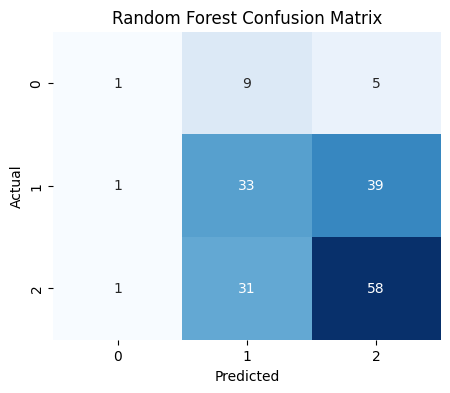

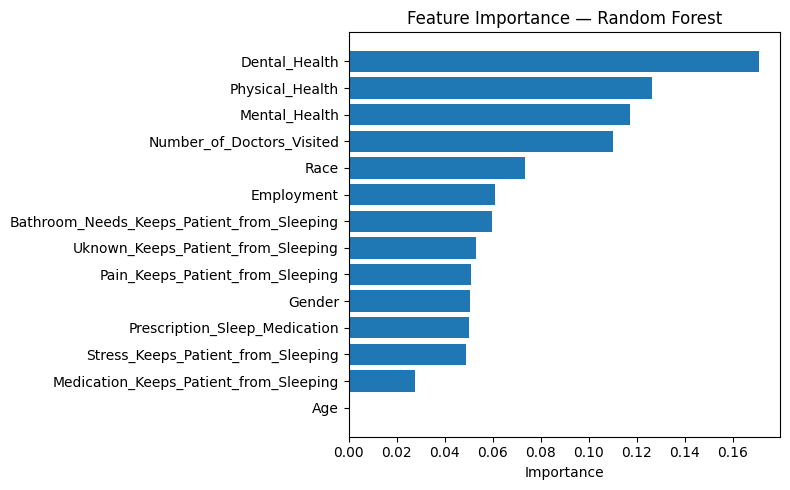

In [17]:
# --- 1️⃣ Logistic Regression ---
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)

print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

# --- 2️⃣ Random Forest ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# --- 3️⃣ Confusion Matrix (for Random Forest) ---
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# --- 4️⃣ Feature Importance (Random Forest) ---
importances = rf.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices][::-1], align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices][::-1])
plt.title("Feature Importance — Random Forest")
plt.xlabel("Importance")
plt.tight_layout()